In [614]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

# Téléchargement des fichiers

## Jeux de données de jouer au Tennis

In [615]:
tenis_df = pd.read_csv('./data/play_tennis.csv')
tenis_df['play'] = tenis_df['play'].map({'No': 0, 'Yes': 1})
tenis_df.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,0
1,D2,Sunny,Hot,High,Strong,0
2,D3,Overcast,Hot,High,Weak,1
3,D4,Rain,Mild,High,Weak,1
4,D5,Rain,Cool,Normal,Weak,1


## Jeux de données des caractères manuscrits

In [616]:
path1 = "./data/traindat.txt"
path2 = "./data/Testdat.txt"

In [617]:
def read_sys_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 9:
                classes, m00, mu02, mu11, mu20, mu03, mu12, mu21, mu30 = str(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7]), float(parts[8])
                data.append((classes, m00, mu02, mu11, mu20, mu03, mu12, mu21, mu30))
    
    return pd.DataFrame(data, columns=["classes", "m00","mu02","mu11","mu20","mu03","mu12","mu21","mu30"])

In [618]:
train_data = read_sys_file(path1)
test_data = read_sys_file(path2)
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Implémentation de GMM

**Etape 0 :** initialiser chaque gaussienne, je prendrai 60% des données afin de calculer la moyenne et la matrice de covariance.

In [619]:
def initialize_g(data, n_estimators):
    G = {}
    for i in range(n_estimators):
        indices = np.random.choice(data.shape[0], size=int(data.shape[0]*0.6), replace=False)
        subset = data[indices]
        subset_mean = np.mean(subset, axis=0)
        subset_cov = np.cov(subset, rowvar=False)
        G[i] = (subset_mean, subset_cov)
    return G

Cette fonction calcule et retourne la probabilité d'appartenance d'un point pour chaque gaussienne.

In [620]:
def calculate_prob(x, parameters):
    return np.array([
        multivariate_normal(mean=mean, cov=cov, allow_singular=True).pdf(x)
        for mean, cov in parameters
    ]).reshape(-1, 1)

**Etape 1 :** Expectation. On calcule la probabilité que chaque donnée appartienne à
chaque gaussienne

In [621]:
def e_step(data, pi, G):
    n_samples, n_estimators = data.shape[0], len(G)
    y = np.zeros((n_samples, n_estimators))
    parameters = list(G.values())
    pi = pi + 1e-10

    for i in range(n_samples):
        f = calculate_prob(data[i], parameters) # On calcule la probabilité que chaque donnée appartienne à chaque gaussienne
        weighted = pi.reshape(-1, 1) * f 
        denominator = np.sum(weighted)
        y[i, :] = (weighted / denominator).flatten() # remplire la matrice y qui contient la probabilité de tout les points
    
    return y

**Etape 2 :** Maximization. On re-estime la moyenne, la matrice de covariance de chaque gaussienne

In [622]:
def m_step(data, y):
    n_samples, n_features = data.shape
    n_estimators = y.shape[1]
    
    N_k = np.sum(y, axis=0) + 1e-10   # On calcule la somme des probabilités pour chaque gaussienne / shape (n_estimators,1)
    new_pi = N_k / n_samples # On calcule les neauvaux pi 
    new_G = {}
    
    new_means = np.dot(y.T, data) / N_k.reshape(n_estimators,1)  # shape (n_estimators, n_features)

    for k in range(n_estimators):
        diff = data - new_means[k]
        weighted_diff = y[:, k].reshape(-1, 1) * diff
        cov_k = np.dot(weighted_diff.T, diff) / N_k[k]
        cov_k += np.eye(n_features) * 1e-6
        new_G[k] = (new_means[k], cov_k)

    return new_pi, new_G

On calcule la vraisemblance totale pour utiliser comme etant une condition de convergance

In [623]:
def compute_log_likelihood(data, pi, G):
    n_samples = data.shape[0]
    parameters = list(G.values())
    log_likelihood = 0
    
    for i in range(n_samples):
        probs = calculate_prob(data[i], parameters)
        weighted_probs = pi.reshape(-1, 1) * probs
        sample_likelihood = np.sum(weighted_probs)
        log_likelihood += np.log(sample_likelihood + 1e-10)
    
    return log_likelihood

Fonction principale qui regroupe toutes les étapes précédentes.

In [624]:
def gaussian_mixture_model(data, n_estimators, eps=1e-4, max_iter=100):
    data = np.asarray(data)
    
    # Etape 0 :
    pi = np.ones(n_estimators) / n_estimators # initialiser le tableau pi par 1 / k gaussienne
    G = initialize_g(data, n_estimators)

    prev_log_likelihood = 0
    for iteration in range(max_iter):
        # Etape 1 : Expectation
        y = e_step(data, pi, G)
        
        # Etape 2 : Maximization
        new_pi, new_G = m_step(data, y) 

        # On calcule la difference entre la vraisemblance prédante et actuelle
        log_likelihood = compute_log_likelihood(data, new_pi, new_G)
        improvement = log_likelihood - prev_log_likelihood
        
        # Condition de convergence
        if iteration > 0 and abs(improvement) < eps:
            print(f"Convergé après {iteration} itérations")
            break
            
        pi, G = new_pi, new_G
        prev_log_likelihood = log_likelihood
    return G

In [625]:
def predict(x, G):
    x = np.asarray(x)
    predictions = np.zeros((x.shape[0], 1))
    
    for i in range(x.shape[0]):
        parameters = list(G.values())
        f = calculate_prob(x[i], parameters)
        predictions[i] = np.argmax(f)
    
    return predictions 

In [626]:
def gmm_fit_predict(data, n_estimators):
    G = gaussian_mixture_model(data, n_estimators)
    predictions = predict(data, G)
    return predictions

# Jeux de données de jouer au Tennis

## Data Encoding

In [627]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

encoded_data = enc.fit_transform(tenis_df.drop('day', axis=1))

encoded_df = pd.DataFrame(data=encoded_data, columns=tenis_df.drop('day', axis=1).columns)

In [628]:
X_tennis = encoded_df.drop('play', axis=1)

## Gaussian Mixture Model

In [629]:
G = gaussian_mixture_model(X_tennis, 2)
tenis_df["my_pred"] = predict(X_tennis, G)

Convergé après 13 itérations


In [630]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X_tennis)
predictions = gmm.predict(X_tennis)
tenis_df['sklearn_pred'] = predictions

In [631]:
tenis_df.head()

,day,outlook,temp,humidity,wind,play,my_pred,sklearn_pred
0,D1,Sunny,Hot,High,Weak,0,0.0,0
1,D2,Sunny,Hot,High,Strong,0,1.0,0
2,D3,Overcast,Hot,High,Weak,1,1.0,0
3,D4,Rain,Mild,High,Weak,1,0.0,0
4,D5,Rain,Cool,Normal,Weak,1,0.0,1


### Evaluation

In [632]:
from sklearn.metrics import precision_score

my_precision = precision_score(tenis_df['play'],tenis_df['my_pred'])
sklearn_precision = precision_score(tenis_df['play'],tenis_df['sklearn_pred'])

print('la précision de modele implémenté est:', my_precision)
print('la précision de modele sklearn est:', sklearn_precision)

la précision de modele implémenté est: 0.8
la précision de modele sklearn est: 0.8


**Remarque :** Notre modèle GMM implémenté donne généralement de très bons résultats comparativement à celui proposé par scikit-learn. Cependant, dans certains cas, c'est l'inverse. Cela s'explique par le fait que l'initialisation des gaussiennes est basée sur 60% des données sélectionnées aléatoirement.

# Jeux de données des caractères manuscrits

## GMM

Le **score Silhouette** est une mesure utilisée pour évaluer la qualité des résultats de classification de données. Ce score est calculé en mesurant la similarité de chaque point de données avec le cluster auquel il appartient et sa différence avec les autres clusters. Le score Silhouette est couramment utilisé pour évaluer les performances des algorithmes de clustering comme K-Means.

* Les valeurs positives indiquent que les points de données appartiennent aux clusters appropriés.
* Un score de zéro suggère des clusters qui se chevauchent ou des points de données à proximité de plusieurs clusters.
* Les valeurs négatives indiquent que les points de données sont attribués à des clusters incorrects, ce qui indique de mauvais résultats de clustering.

In [633]:
X_mnist = all_data.drop('classes', axis=1)

In [634]:
from sklearn.metrics import silhouette_score 

estimators = [2, 4, 6, 8, 10] 
silhouette_scores_sklearn = []

for k in estimators:
    pred = GaussianMixture(n_components=k).fit_predict(X_mnist)
    silhouette_scores_sklearn.append(silhouette_score(X_mnist, pred))  

In [635]:
silhouette_scores_mine = []

for k in estimators:
    pred = gmm_fit_predict(X_mnist, k)
    silhouette_scores_mine.append(silhouette_score(X_mnist, pred))  

Convergé après 1 itérations
Convergé après 1 itérations
Convergé après 1 itérations
Convergé après 1 itérations
Convergé après 1 itérations


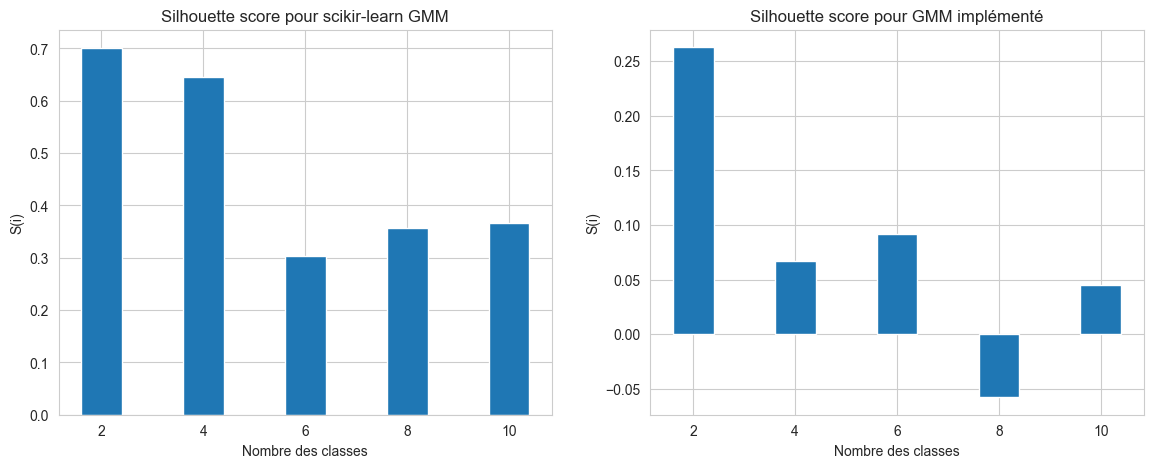

In [636]:
plt.subplots(1,2, figsize=(14,5))

plt.subplot(1, 2, 1)
plt.bar(estimators, silhouette_scores_sklearn) 
plt.xlabel('Nombre des classes') 
plt.ylabel('S(i)') 
plt.title('Silhouette score pour scikir-learn GMM')

plt.subplot(1, 2, 2)
plt.bar(estimators, silhouette_scores_mine) 
plt.xlabel('Nombre des classes') 
plt.ylabel('S(i)') 
plt.title('Silhouette score pour GMM implémenté')

plt.show() 

**Remarque :** On constate que pour les deux GMM, le nombre optimal de classes est 2, alors que le k réel est 10. Pour k=10, le modèle GMM implémenté a donné un score de silhouette négatif, ce qui indique que le modèle a mal prédit les données.

## Dendrogram

### Comparaison entre différents types de liens

In [637]:
from sklearn.cluster import AgglomerativeClustering

In [638]:
silhouette_score_dendrogram = [] 
linkage = ['single', 'average', 'complete', 'ward']

for link in linkage:
    model_dendro = AgglomerativeClustering(n_clusters=10, linkage=link, metric="euclidean").fit(X_mnist)
    pred_dendro = model_dendro.labels_
    silhouette_score_dendrogram.append(silhouette_score(X_mnist, pred_dendro))  

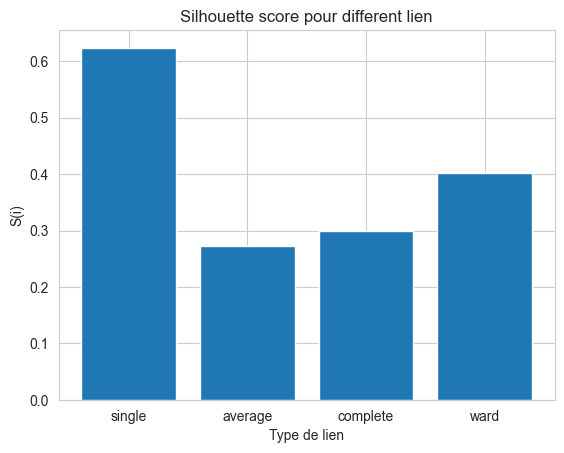

In [639]:
plt.bar(linkage, silhouette_score_dendrogram) 
plt.xlabel('Type de lien') 
plt.ylabel('S(i)') 
plt.title('Silhouette score pour different lien')

plt.show() 

**Remarque :** Pour ce jeu de données, le lien simple obtient le meilleur score de silhouette, suivie de Ward.

### Comparaison entre différents k classes pour lien simple

In [640]:
silhouette_score_dendrogram = []
n_clusters_list = [i for i in range(2,11)]

for n in n_clusters_list:
    model_dendro = AgglomerativeClustering(n_clusters=n, linkage='single', metric="euclidean")
    pred_dendro = model_dendro.fit_predict(X_mnist)
    score = silhouette_score(X_mnist, pred_dendro)
    silhouette_score_dendrogram.append(score)

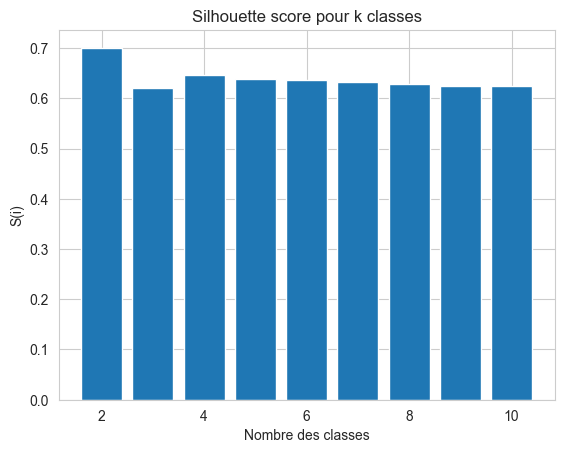

In [641]:
plt.bar(n_clusters_list, silhouette_score_dendrogram) 
plt.xlabel('Nombre des classes') 
plt.ylabel('S(i)') 
plt.title('Silhouette score pour k classes')

plt.show() 

**Reamrque :** On constate que le nombre de classe maximale est 2, ensuite 4 et 5, alors que k reél est 10.